<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8%2C%20%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%20%D0%BD%D0%B0%20%D0%B1%D0%B0%D0%B7%D0%B5%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 15.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.0 which is incompatible.
     |████████████████████████████████| 44.5MB 72kB/s 


In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import seaborn as sns # более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
#from keras.datasets import fashion_mnist # загружаем готовую базу mnist(fashion- с одеждой, обувью и т.п)

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from keras.layers import Input, Dense  # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса

from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации отдельным слоем
from keras import backend as K # устанавливаем переменную для окружения кераса
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarn

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # загружаем данные из базы fashion_mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

**РАЗМЕР СКРЫТОГО ПРОСТРАНСТВА = 10**

In [ ]:
batch_size = 500 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))
        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)


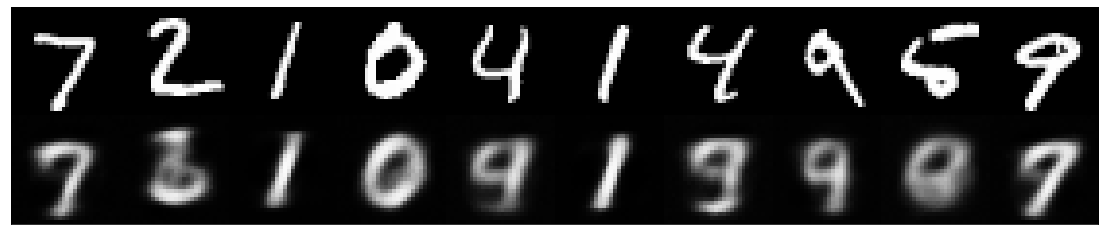

60000/60000 [==============================] - 23s - loss: 0.1111 - val_loss: 0.0986
Epoch 17/20
60000/60000 [==============================] - 22s - loss: 0.1091 - val_loss: 0.0970
Epoch 18/20
60000/60000 [==============================] - 22s - loss: 0.1075 - val_loss: 0.0957
Epoch 19/20
60000/60000 [==============================] - 22s - loss: 0.1059 - val_loss: 0.0945
Epoch 20/20
60000/60000 [==============================] - 21s - loss: 0.1047 - val_loss: 0.0934


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
flatten_3 (Flatten)          (500, 784)                0         
_________________________________________________________________
dense_15 (Dense)             (500, 256)                200960    
_________________________________________________________________
batch_normalization_9 (Batch (500, 256)                1024      
_________________________________________________________________
dropout_9 (Dropout)          (500, 256)                0         
_________________________________________________________________
dense_16 (Dense)             (500, 128)                32896     
_________________________________________________________________
batch_normalization_10 (Batc (500, 128)                512       
__________

In [ ]:
def plot_images(generator, examples=10, dim=(10,10), figsize=(15,15)): # функция добавляет шум на скрытом пространстве
    k = 1.1
    noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем шум нормальным распределением
    
    im_arr = [generator.predict((k**i)*noise) for i in range(0,examples)] # получаем сгенеренные выходные картинки над заданным шумом
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()

In [ ]:
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
    
    noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем первое случайное зашумленное распределение
    noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем второе случайное зашумленное распределение
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()

In [ ]:
z_imgs = models['encoder'].predict(x_test[:500], batch_size=500)

In [ ]:
print(z_imgs.shape)

(500, 10)


In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
    
    index1 = int(round(200*np.random.sample(1)[0])) # запишем в первый индекс случайно сгенерированное значение
    index2 = int(round(200*np.random.sample(1)[0])) # запишем во второй индекс случайно сгенерированное значение
    noise1 = z_imgs[index1,:].reshape(1,10) # сгенерируем первую зашумленную картинку по полученному индексу
    noise2 = z_imgs[index2,:].reshape(1,10) # сгенерируем вторую зашумленную картинку по полученному индексу
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()

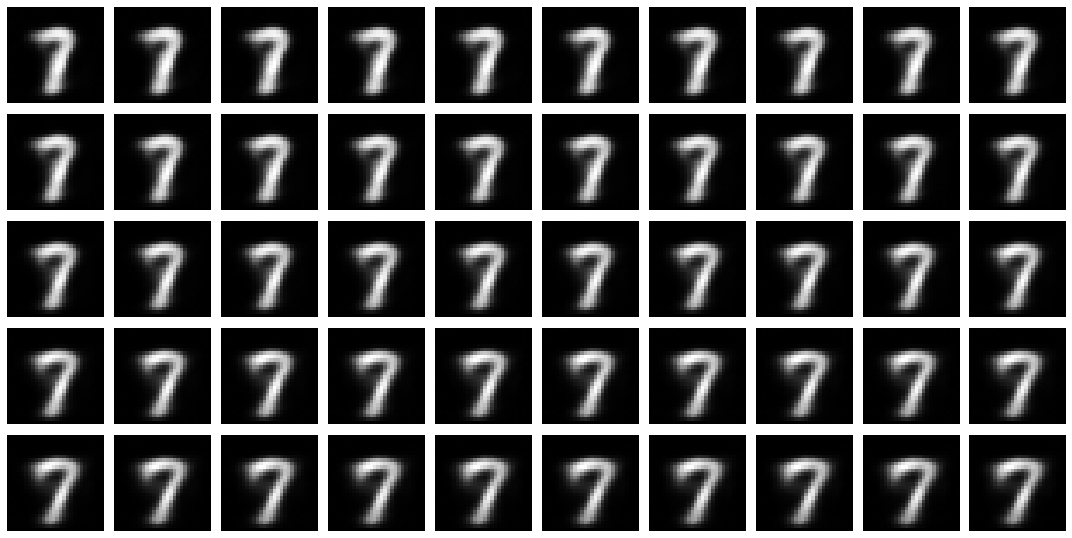

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=50) # отрисовываем картинки

**РАЗМЕР СКРЫТОГО ПРОСТРАНСТВА 20**

In [ ]:
batch_size = 500 # размер батча
latent_dim = 20 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения


models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры цифр


n = 15 # Картинка с 15x15 цифр
digit_size = 28

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)


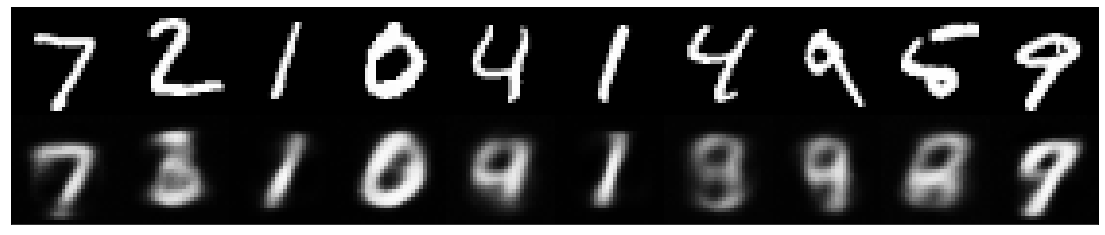

60000/60000 [==============================] - 22s - loss: 0.1133 - val_loss: 0.1001
Epoch 17/20
60000/60000 [==============================] - 21s - loss: 0.1115 - val_loss: 0.0988
Epoch 18/20
60000/60000 [==============================] - 23s - loss: 0.1100 - val_loss: 0.0977
Epoch 19/20
60000/60000 [==============================] - 23s - loss: 0.1086 - val_loss: 0.0967
Epoch 20/20
60000/60000 [==============================] - 23s - loss: 0.1074 - val_loss: 0.0958


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [ ]:
z_imgs = models['encoder'].predict(x_test[:500], batch_size=500)

**РАЗМЕР СКРЫТОГО ПРОСТРАНСТВА 100**

In [ ]:
batch_size = 500 # размер батча
latent_dim = 100 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения


models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры цифр


n = 15 # Картинка с 15x15 цифр
digit_size = 28

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)


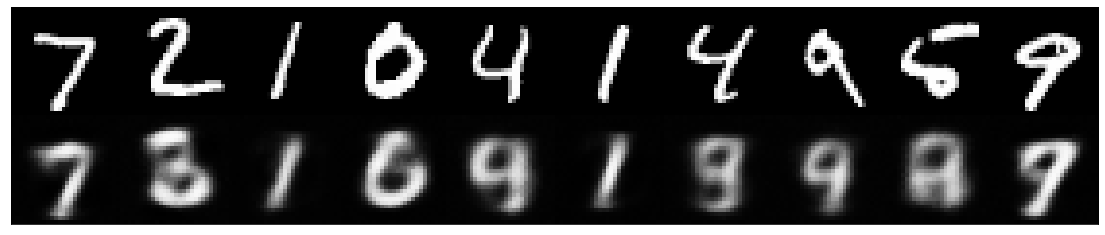

60000/60000 [==============================] - 24s - loss: 0.1208 - val_loss: 0.1046
Epoch 17/20
60000/60000 [==============================] - 23s - loss: 0.1191 - val_loss: 0.1037
Epoch 18/20
60000/60000 [==============================] - 22s - loss: 0.1175 - val_loss: 0.1029
Epoch 19/20
60000/60000 [==============================] - 22s - loss: 0.1159 - val_loss: 0.1021
Epoch 20/20
60000/60000 [==============================] - 23s - loss: 0.1147 - val_loss: 0.1015


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [ ]:
z_imgs = models['encoder'].predict(x_test[:500], batch_size=500)

**РАЗМЕР СКРЫТОГО ПРОСТРАНСТВА 200**

In [ ]:
batch_size = 500 # размер батча
latent_dim = 200 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения


models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

digit_size = 28 # задаем размеры цифр


n = 15 # Картинка с 15x15 цифр
digit_size = 28

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)


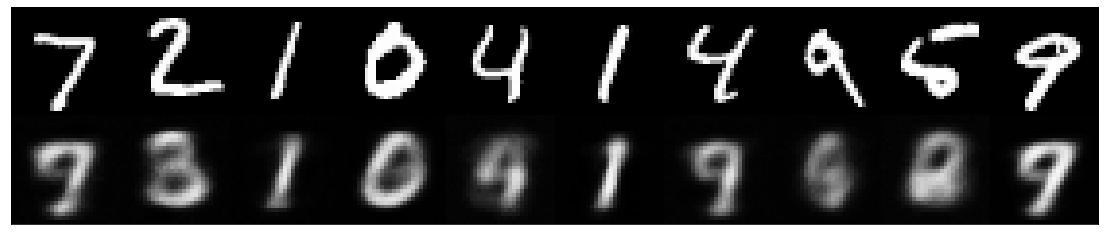

60000/60000 [==============================] - 24s - loss: 0.1212 - val_loss: 0.1053
Epoch 17/20
60000/60000 [==============================] - 24s - loss: 0.1193 - val_loss: 0.1044
Epoch 18/20
60000/60000 [==============================] - 24s - loss: 0.1176 - val_loss: 0.1035
Epoch 19/20
60000/60000 [==============================] - 24s - loss: 0.1161 - val_loss: 0.1028
Epoch 20/20
60000/60000 [==============================] - 24s - loss: 0.1148 - val_loss: 0.1021


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

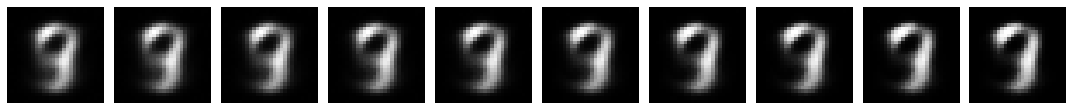

In [ ]:
plot_images(generator) # размер пространства 10

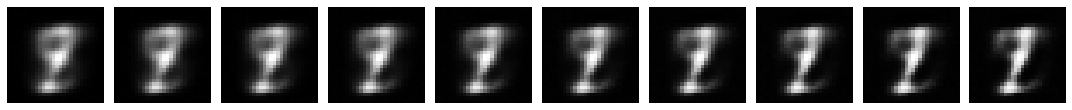

In [ ]:
plot_images(generator) # размер пространства 20

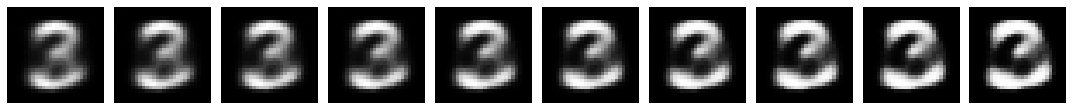

In [ ]:
plot_images(generator) # размер пространства 100

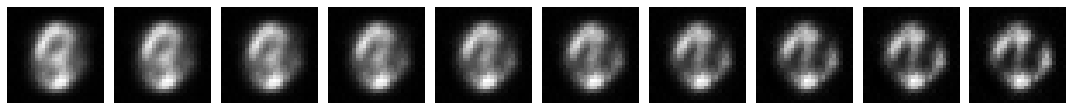

In [ ]:
plot_images(generator) # размер пространства 200

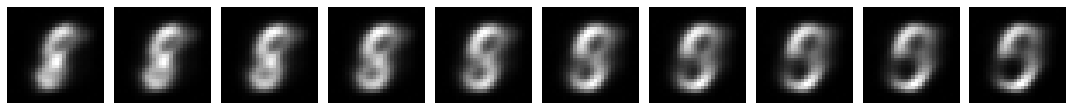

In [ ]:
plot_images_two_points(generator) # размер пространства 10

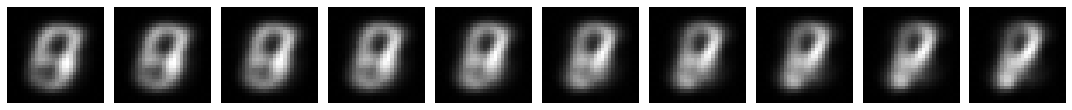

In [ ]:
plot_images_two_points(generator) # размер пространства 20

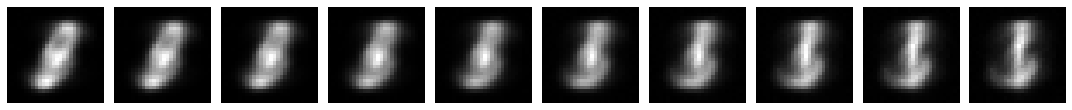

In [ ]:
plot_images_two_points(generator) # размер пространства 100

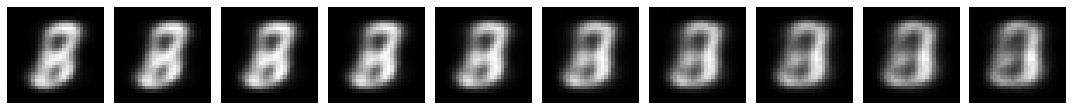

In [ ]:
plot_images_two_points(generator) # размер пространства 200

Как видно из ячейки "plot_images(generator) # размер пространства 100"
скрытое пространство размером 100 - лучше всех подходит для данной задачи, видимо это оптимальная размерность, чтобы VAE смог максимально сблизить точки в скрытом пространстве.

**Сверточный VAE**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

In [ ]:
batch_size = 100 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_conv_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    # x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    # x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    # x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    # x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    # x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img) # входные данные передаем на слой двумерной свёртки
    x = MaxPooling2D((2, 2), padding='same')(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных
    # x = Conv2D(32, (2, 2), activation='relu', padding='same')(x) # второй слой двумерной свёртки
    # x = MaxPooling2D((2, 2), padding='same')(x) # второй слой подвыборки
    x = Flatten()(x)
    


    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    # x = Dense(128)(z) # полносвязный слой на 128 нейронов
    # x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    # x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    # x = Dense(256)(x) # полносвязный слой на 256 нейронов
    # x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    # x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    # x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    # decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам
    x = Dense(7*7)(z)
    x = Reshape(target_shape=(7, 7, 1))(x)
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x) # входные данные передаем на слой двумерной свёртки
    # x = UpSampling2D((2, 2))(x)  # Conv2DTranspose. Cлой разжимает данные, стало 14на14
    # x = Conv2D(128, (2, 2), activation='relu', padding='same')(x) # второй слой двумерной свёртки
    x = UpSampling2D((4, 4))(x) # второй слой разжатия данных, стало 28на28
    x = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x) # финальный слой свертки энкодера
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам
    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["conv_vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='CONV_VAE')

    def conv_vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, conv_vae_loss

models, conv_vae_loss = create_conv_vae() # получаем модели и свою функцию потерь
conv_vae = models["conv_vae"] # задаем модель вариационного автокодировщика

conv_vae.compile(optimizer=Adam(start_lr), loss=conv_vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
models['conv_vae'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (100, 28, 28, 1)          0         
_________________________________________________________________
Encoder (Model)              (100, 10)                 54196     
_________________________________________________________________
Decoder (Model)              multiple                  3708      
Total params: 57,904.0
Trainable params: 57,904.0
Non-trainable params: 0.0
_________________________________________________________________


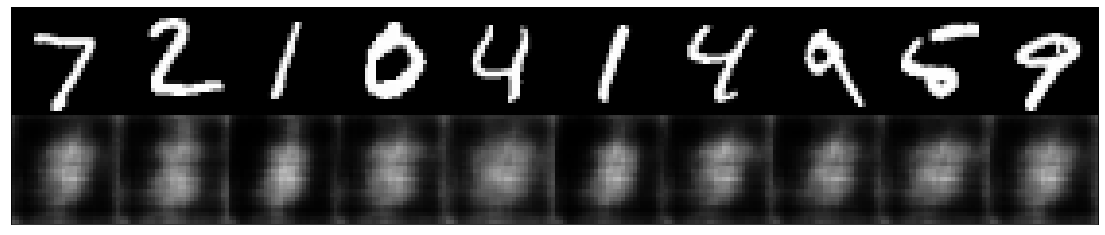

1000/1000 [==============================] - 67s - loss: 0.1669 - val_loss: 0.1678
Epoch 17/20
1000/1000 [==============================] - 52s - loss: 0.1633 - val_loss: 0.1647
Epoch 18/20
1000/1000 [==============================] - 52s - loss: 0.1605 - val_loss: 0.1619
Epoch 19/20
1000/1000 [==============================] - 52s - loss: 0.1582 - val_loss: 0.1596
Epoch 20/20
1000/1000 [==============================] - 52s - loss: 0.1558 - val_loss: 0.1574


In [ ]:
# Запуск обучения 
conv_vae.fit(x_train[:1000], x_train[:1000], shuffle=True, epochs=20, # взял всего тысячу примеров из обучающей выборки, время обучения взлетало до небес
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

Как видно по результатам на последней эпохе, сверточный автокодировщик, вероятнее всего не доучился, так как на вход был подан слишком маленький набор данных, по ошибке видно, что она стабильно уменьшалась, выводы сделать сложно, необходимо дообучение.

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28

# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = conv_vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))
        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)


# LIGHT CVAE

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test).astype(np.float32) # переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

In [ ]:
batch_size = 500 # размер батча
latent_dim = 8 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

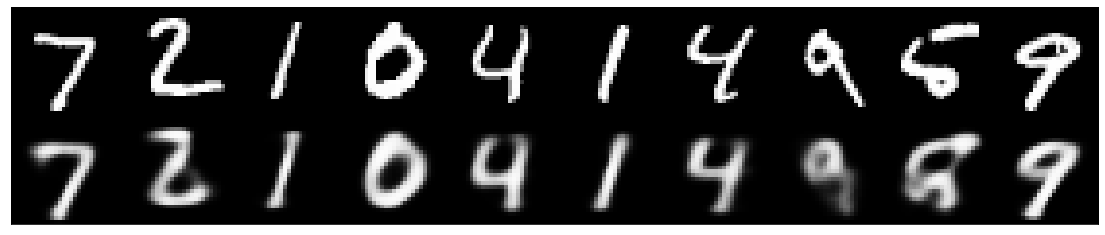

60000/60000 [==============================] - 19s - loss: 0.0823 - val_loss: 0.0763
Epoch 17/20
60000/60000 [==============================] - 18s - loss: 0.0822 - val_loss: 0.0761
Epoch 18/20
60000/60000 [==============================] - 18s - loss: 0.0821 - val_loss: 0.0759
Epoch 19/20
60000/60000 [==============================] - 18s - loss: 0.0820 - val_loss: 0.0758
Epoch 20/20
60000/60000 [==============================] - 18s - loss: 0.0819 - val_loss: 0.0755


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=20,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

теперь попробуем дообучить ещё на нескольких эпохах, так как видно, что ошибка уменьшается, видимо есть ещё возможность дообучаться


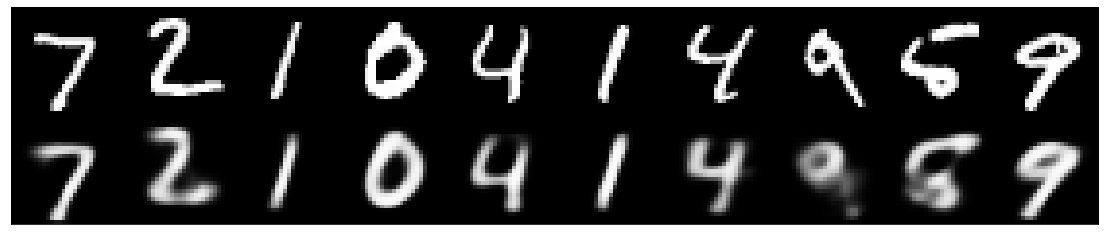

60000/60000 [==============================] - 18s - loss: 0.0803 - val_loss: 0.0740
Epoch 47/50
60000/60000 [==============================] - 18s - loss: 0.0803 - val_loss: 0.0739
Epoch 48/50
60000/60000 [==============================] - 18s - loss: 0.0803 - val_loss: 0.0739
Epoch 49/50
60000/60000 [==============================] - 18s - loss: 0.0803 - val_loss: 0.0739
Epoch 50/50
60000/60000 [==============================] - 18s - loss: 0.0803 - val_loss: 0.0739


In [ ]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=50,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1)

видно, что ошибка с достигла своего минимума с этой архитектурой, попробуем добавить слоёв

Теперь попробуем обучить с большим числом слоёв Dense

In [ ]:
def create_cvae_new(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(768, activation='relu')(x) 
    
    x = apply_bn_and_dropout(x) 
    
    x = Dense(512, activation='relu')(x) 
    
    x = apply_bn_and_dropout(x)

    x = Dense(256, activation='relu')(x) 
    
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(768)(x) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x)
    x = Dense(512)(x) 
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x) 
    x = Dense(256)(x) 
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x) 
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models_new, vae_loss = create_cvae_new() # получаем модели и свою функцию потерь
cvae_new = models_new["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae_new.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

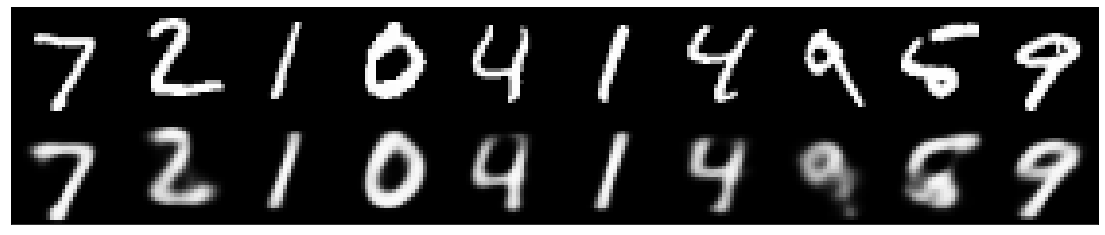

60000/60000 [==============================] - 75s - loss: 0.2655 - val_loss: 0.1377


In [ ]:
# Посмотрим, насколько долго будет обучатся эта модель на одной эпохе, 
# чтобы примерно понимать масштабы происходящего
cvae_new.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=20,
              batch_size=batch_size,
              validation_data=([x_test, y_test_cat, y_test_cat], x_test),
              callbacks=[pltfig, tb],
              verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

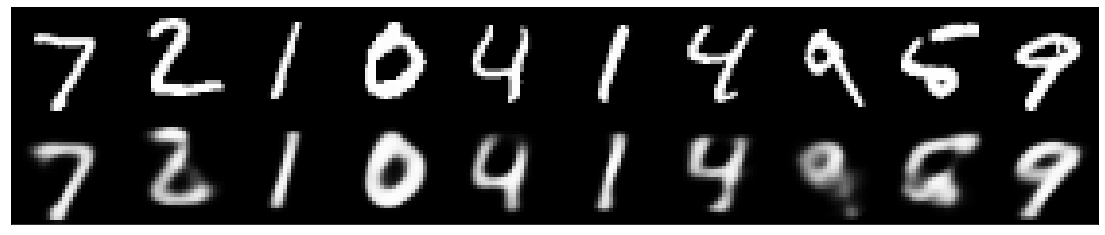

60000/60000 [==============================] - 72s - loss: 0.0795 - val_loss: 0.0710
Epoch 27/30
60000/60000 [==============================] - 72s - loss: 0.0794 - val_loss: 0.0709
Epoch 28/30
60000/60000 [==============================] - 71s - loss: 0.0792 - val_loss: 0.0707
Epoch 29/30
60000/60000 [==============================] - 71s - loss: 0.0791 - val_loss: 0.0708
Epoch 30/30
60000/60000 [==============================] - 71s - loss: 0.0790 - val_loss: 0.0705


In [ ]:
# теперь запускаем обучение 
cvae_new.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=30,
              batch_size=batch_size,
              validation_data=([x_test, y_test_cat, y_test_cat], x_test),
              callbacks=[pltfig, tb],
              verbose=1)

видим что ошибка уменьшается (и она уже меньше, чем на первой архитектуре) и можно попробовать дообучить ещё на нескольких эпохах,

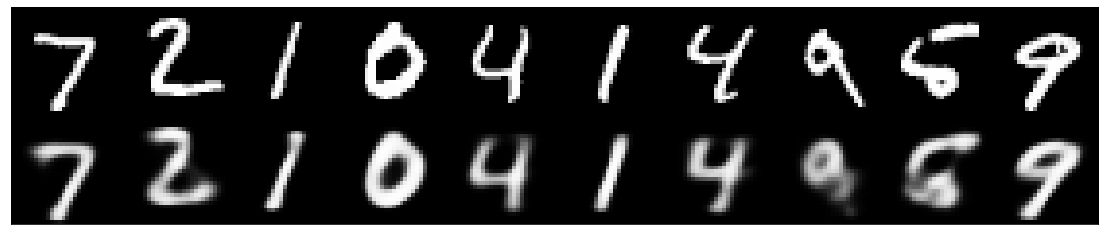

60000/60000 [==============================] - 78s - loss: 0.0783 - val_loss: 0.0698
Epoch 7/10
60000/60000 [==============================] - 79s - loss: 0.0782 - val_loss: 0.0697
Epoch 8/10
60000/60000 [==============================] - 79s - loss: 0.0781 - val_loss: 0.0696
Epoch 9/10
60000/60000 [==============================] - 79s - loss: 0.0780 - val_loss: 0.0695
Epoch 10/10
60000/60000 [==============================] - 78s - loss: 0.0779 - val_loss: 0.0694


In [ ]:
# теперь запускаем обучение 
cvae_new.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=10,
              batch_size=batch_size,
              validation_data=([x_test, y_test_cat, y_test_cat], x_test),
              callbacks=[pltfig, tb],
              verbose=1)

в случае использования второй архитектуры видно, что после 31ой эпохи (на этапе дообучения) начали прорисовываться девятка и пятерка (третья и вторая картинки справа). Значит по величине ошибки можно косвенно судить о возможностях архитектуры к более качественному воспроизведению исходных изображений.

In [ ]:
import random
rand_x = np.random.random(size=(8,))
rand_x = rand_x.reshape((1,8))

rand_y = y_train_cat[random.randint(0, len(y_train_cat))]
rand_y = rand_y.reshape((1,10))

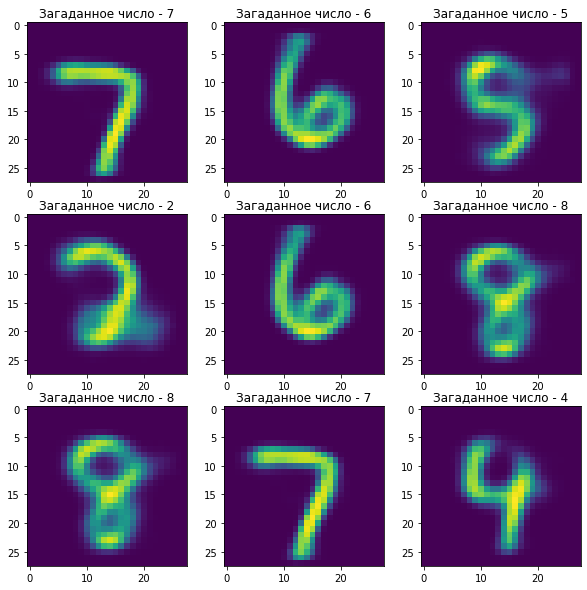

In [ ]:
decoder = models_new['decoder']
plt.figure(figsize=(10,10))
for i in range(9):
  y = y_train_cat[random.randint(0, len(y_train_cat))]
  rand_y = y.reshape((1,10))
  pred_rand = decoder.predict([rand_x, rand_y])
  pred_rand = pred_rand.reshape((28,28))
  plt.subplot(3, 3, i+1)
  plt.imshow(pred_rand)
  plt.title(f'Загаданное число - {y.argmax()}')
plt.show()

Видим что из одного и того же случайного шума наш декодер восстанавливает картинки согласно заданным меткам

Сделаем генерацию с помощью VAE баз Fashion mnist и Cifar10


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Lambda, LeakyReLU, Reshape, Conv2D, BatchNormalization, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend
from IPython.display import clear_output
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

In [ ]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

In [ ]:
batch_size = 500
latent_dim = 10
dropout_rate = 0.3
start_lr = 1e-4

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Sampling(layers.Layer):

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
from tensorflow.keras.layers import Dense

In [ ]:
latent_dim = 2

encoder_inputs = Input(shape=(28,28,1))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = Input(shape=(latent_dim,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z= encoder(data)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(binary_crossentropy(data, reconstruction))
      reconstruction_loss *= 28 * 28
      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)

    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        'loss' : total_loss,
        'reconstruction_loss': reconstruction_loss,
        'kl_loss': kl_loss,
        }

In [ ]:
(x_train, _),(x_test, _) = fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 8ms/step - loss: 309.5841 - reconstruction_loss: 306.4339 - kl_loss: 3.1502
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 269.4951 - reconstruction_loss: 266.0811 - kl_loss: 3.4140
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 266.0338 - reconstruction_loss: 262.6035 - kl_loss: 3.4304
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 264.5117 - reconstruction_loss: 261.0496 - kl_loss: 3.4620
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 263.4029 - reconstruction_loss: 259.9382 - kl_loss: 3.4647
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 262.5095 - reconstruction_loss: 259.0256 - kl_loss: 3.4839
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 261.7996 - reconstruction_loss: 258.3149 - kl_loss: 3.4848
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - l

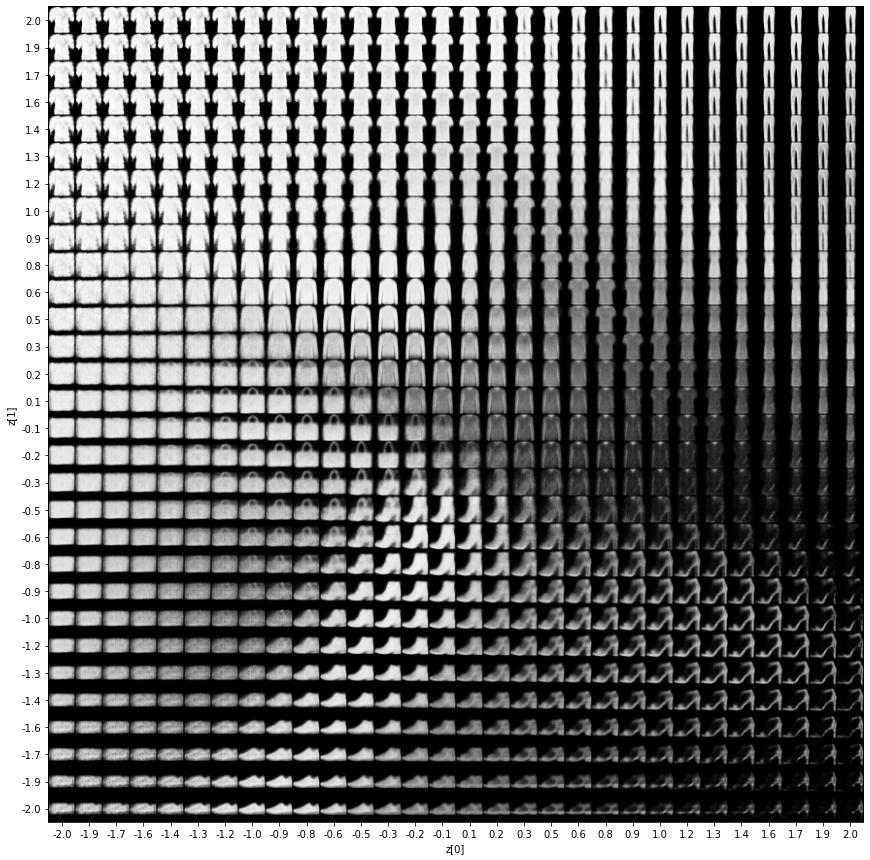

In [ ]:
def plot_latent(encoder, decoder):
  n = 30
  digit_size = 28
  scale = 2.0
  figsize = 15
  figure = np.zeros((digit_size * n, digit_size * n))  
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
              i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size,
      ] = digit
  
  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z[0]')
  plt.ylabel('z[1]')
  plt.imshow(figure, cmap='Greys_r')
  plt.show()


plot_latent(encoder, decoder)